In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [2]:
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# src_path = os.path.join(project_root, "src")

if project_root not in sys.path:
    sys.path.append(project_root)

# Get data

In [3]:
data_dir_path = os.path.join("..", "data", "gridloss", "train.csv")
df = pd.read_csv(data_dir_path, index_col=0)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   demand                     17518 non-null  float64
 1   grid1-load                 17520 non-null  float64
 2   grid1-loss                 17519 non-null  float64
 3   grid1-loss-prophet-daily   16775 non-null  float64
 4   grid1-loss-prophet-pred    16775 non-null  float64
 5   grid1-loss-prophet-trend   16775 non-null  float64
 6   grid1-loss-prophet-weekly  16775 non-null  float64
 7   grid1-loss-prophet-yearly  16775 non-null  float64
 8   grid1-temp                 17518 non-null  float64
 9   grid2-load                 17520 non-null  float64
 10  grid2-loss                 17519 non-null  float64
 11  grid2-loss-prophet-daily   16775 non-null  float64
 12  grid2-loss-prophet-pred    16775 non-null  float64
 13  grid2-loss-

In [4]:
# Backfill missing data
df = df.bfill()

# Separate grids

In [5]:
grid1_columns  = ["grid1-load", "grid1-loss", "grid1-temp"]
grid2_columns  = ["grid2-load", "grid2-loss", "grid2_1-temp"]
grid3_columns  = ["grid3-load", "grid3-loss", "grid3-temp"]

In [6]:
grid1_df = df[grid1_columns]
grid2_df = df[grid2_columns]
grid3_df = df[grid3_columns]

# Stats per grid

In [7]:
grid1_df.describe()

,grid1-load,grid1-loss,grid1-temp
count,17520.000000,17520.000000,17520.000000
mean,356.142701,19.008168,279.586981
std,121.733856,10.042511,7.861111
min,117.339000,5.030000,255.950000
25%,252.835500,10.866000,273.750000
50%,353.764000,16.480550,279.050000
75%,453.433250,25.145250,285.550000
max,663.245000,59.186000,304.150000


In [8]:
grid2_df.describe()

,grid2-load,grid2-loss,grid2_1-temp
count,17520.000000,17520.000000,17520.000000
mean,164.612494,12.862116,274.102637
std,27.005070,8.057992,9.279293
min,64.275600,4.398000,244.153214
25%,144.126250,8.935517,267.552517
50%,163.722000,10.544950,273.672729
75%,185.206000,13.074125,281.204895
max,244.249000,55.485000,301.089100


In [9]:
grid3_df.describe()

,grid3-load,grid3-loss,grid3-temp
count,17520.000000,17520.000000,17520.000000
mean,10.944555,1.077764,277.217144
std,3.803330,0.230054,7.561361
min,5.628100,0.000000,255.893784
25%,7.456200,0.977000,271.903664
50%,9.760200,1.003855,276.873953
75%,13.925275,1.068737,282.647774
max,22.987200,2.793290,302.930800


# Convert to numpy dataset

In [10]:
from src.utils.generate_dataset import generate_windows_dataset

def df_to_dataset(df, columns):
    df.index = pd.to_datetime(df.index)
    mts_dataset = generate_windows_dataset(
        df, 
        window_size = 192, 
        step_size=24, 
        include_columns=columns
    )
    
    mts_dataset_numpy = np.array([df.values.T for df in mts_dataset])
    return mts_dataset_numpy

grid1_dataset = df_to_dataset(grid1_df, grid1_columns)
print(grid1_dataset.shape)
grid2_dataset = df_to_dataset(grid2_df, grid2_columns)
print(grid2_dataset.shape)
grid3_dataset = df_to_dataset(grid3_df, grid3_columns)
print(grid3_dataset.shape)
    

100%|██████████| 723/723 [00:00<00:00, 41081.08it/s]


(723, 3, 192)


100%|██████████| 723/723 [00:00<00:00, 37498.23it/s]


(723, 3, 192)


100%|██████████| 723/723 [00:00<00:00, 45176.64it/s]

(723, 3, 192)


# Features and decomps

In [12]:
from src.utils.generate_dataset import generate_feature_dataframe

grid1_features, grid1_decomps = generate_feature_dataframe(
    grid1_dataset, 
    series_periodicity=24,
    num_features_per_uts=4
)

grid2_features, grid2_decomps = generate_feature_dataframe(
    grid2_dataset, 
    series_periodicity=24,
    num_features_per_uts=4
)

grid3_features, grid3_decomps = generate_feature_dataframe(
    grid3_dataset, 
    series_periodicity=24,
    num_features_per_uts=4
)

100%|██████████| 723/723 [00:14<00:00, 50.14it/s]


# PCA
Not sure whether to fit PCA to grid1 data set and transform the other grids accordingly or to fit PCA to the combination of all grids. 
The former makes more sense if the context is to view grid1 as some kind of "source" data set and the other grids as "targets" to which we want to transform/augment the source-data. 
The latter may be more informative if the point is to simply increase the dataset size.

Try both. Or maybe just fit each grid respectively. Try that first.

## PCA fit each grid respectively

In [13]:
print(grid1_features.shape)

(723, 12)


In [14]:
from sklearn.decomposition import PCA

def mts_and_uts_wise_pca(mts_features):
    num_uts = 3
    num_features = 4
    uts_features = mts_features.reshape(mts_features.shape[0], num_uts, num_features)

    pca_list = []
    # MTS PCA
    pca = PCA(n_components=2)
    mts_pca = pca.fit_transform(mts_features)
    pca_list.append(mts_pca)
    # UTS PCA
    for i in range(num_uts):
        pca = PCA(n_components=2)
        uts_pca = pca.fit_transform(uts_features[:, i, :])
        pca_list.append(uts_pca)
        
    return pca_list

In [15]:
grid1_pca_list = mts_and_uts_wise_pca(grid1_features)
grid2_pca_list = mts_and_uts_wise_pca(grid2_features)
grid3_pca_list = mts_and_uts_wise_pca(grid3_features)

In [29]:
def plot_pca(pca_list, title):
    fig, axes = plt.subplots(len(pca_list), 1, figsize=(15, 20))
    fig.suptitle(title)
    
    for i, pca in enumerate(pca_list):
        axes[i].scatter(pca[:, 0], pca[:, 1])
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")  
        
    plt.tight_layout()  
    plt.show()

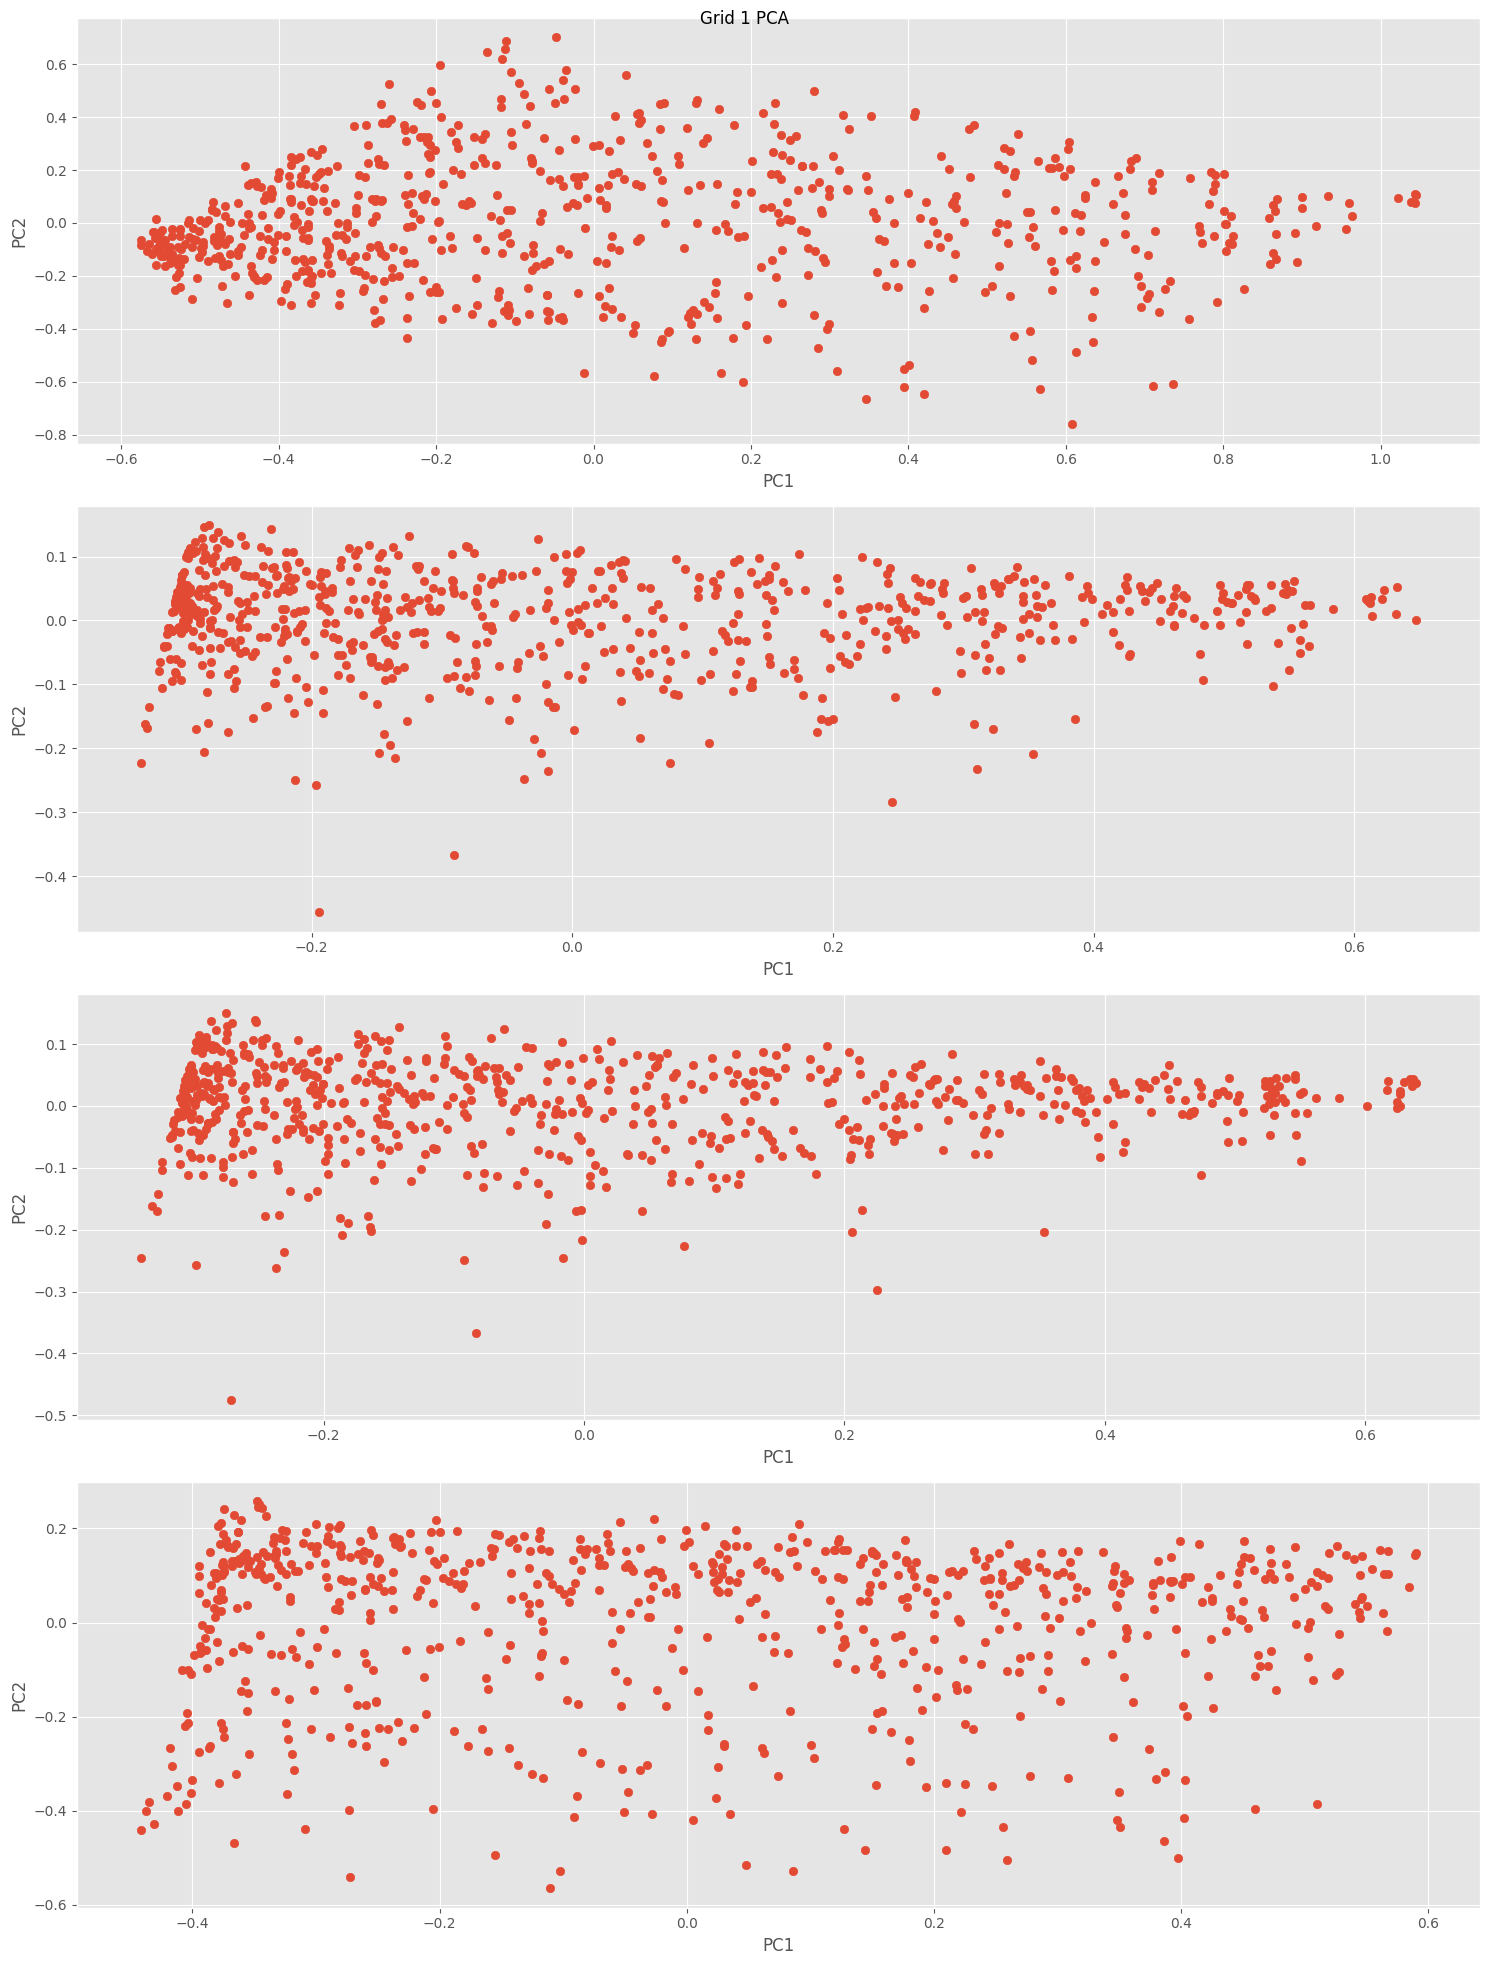

In [30]:
plot_pca(grid1_pca_list, "Grid 1 PCA") 

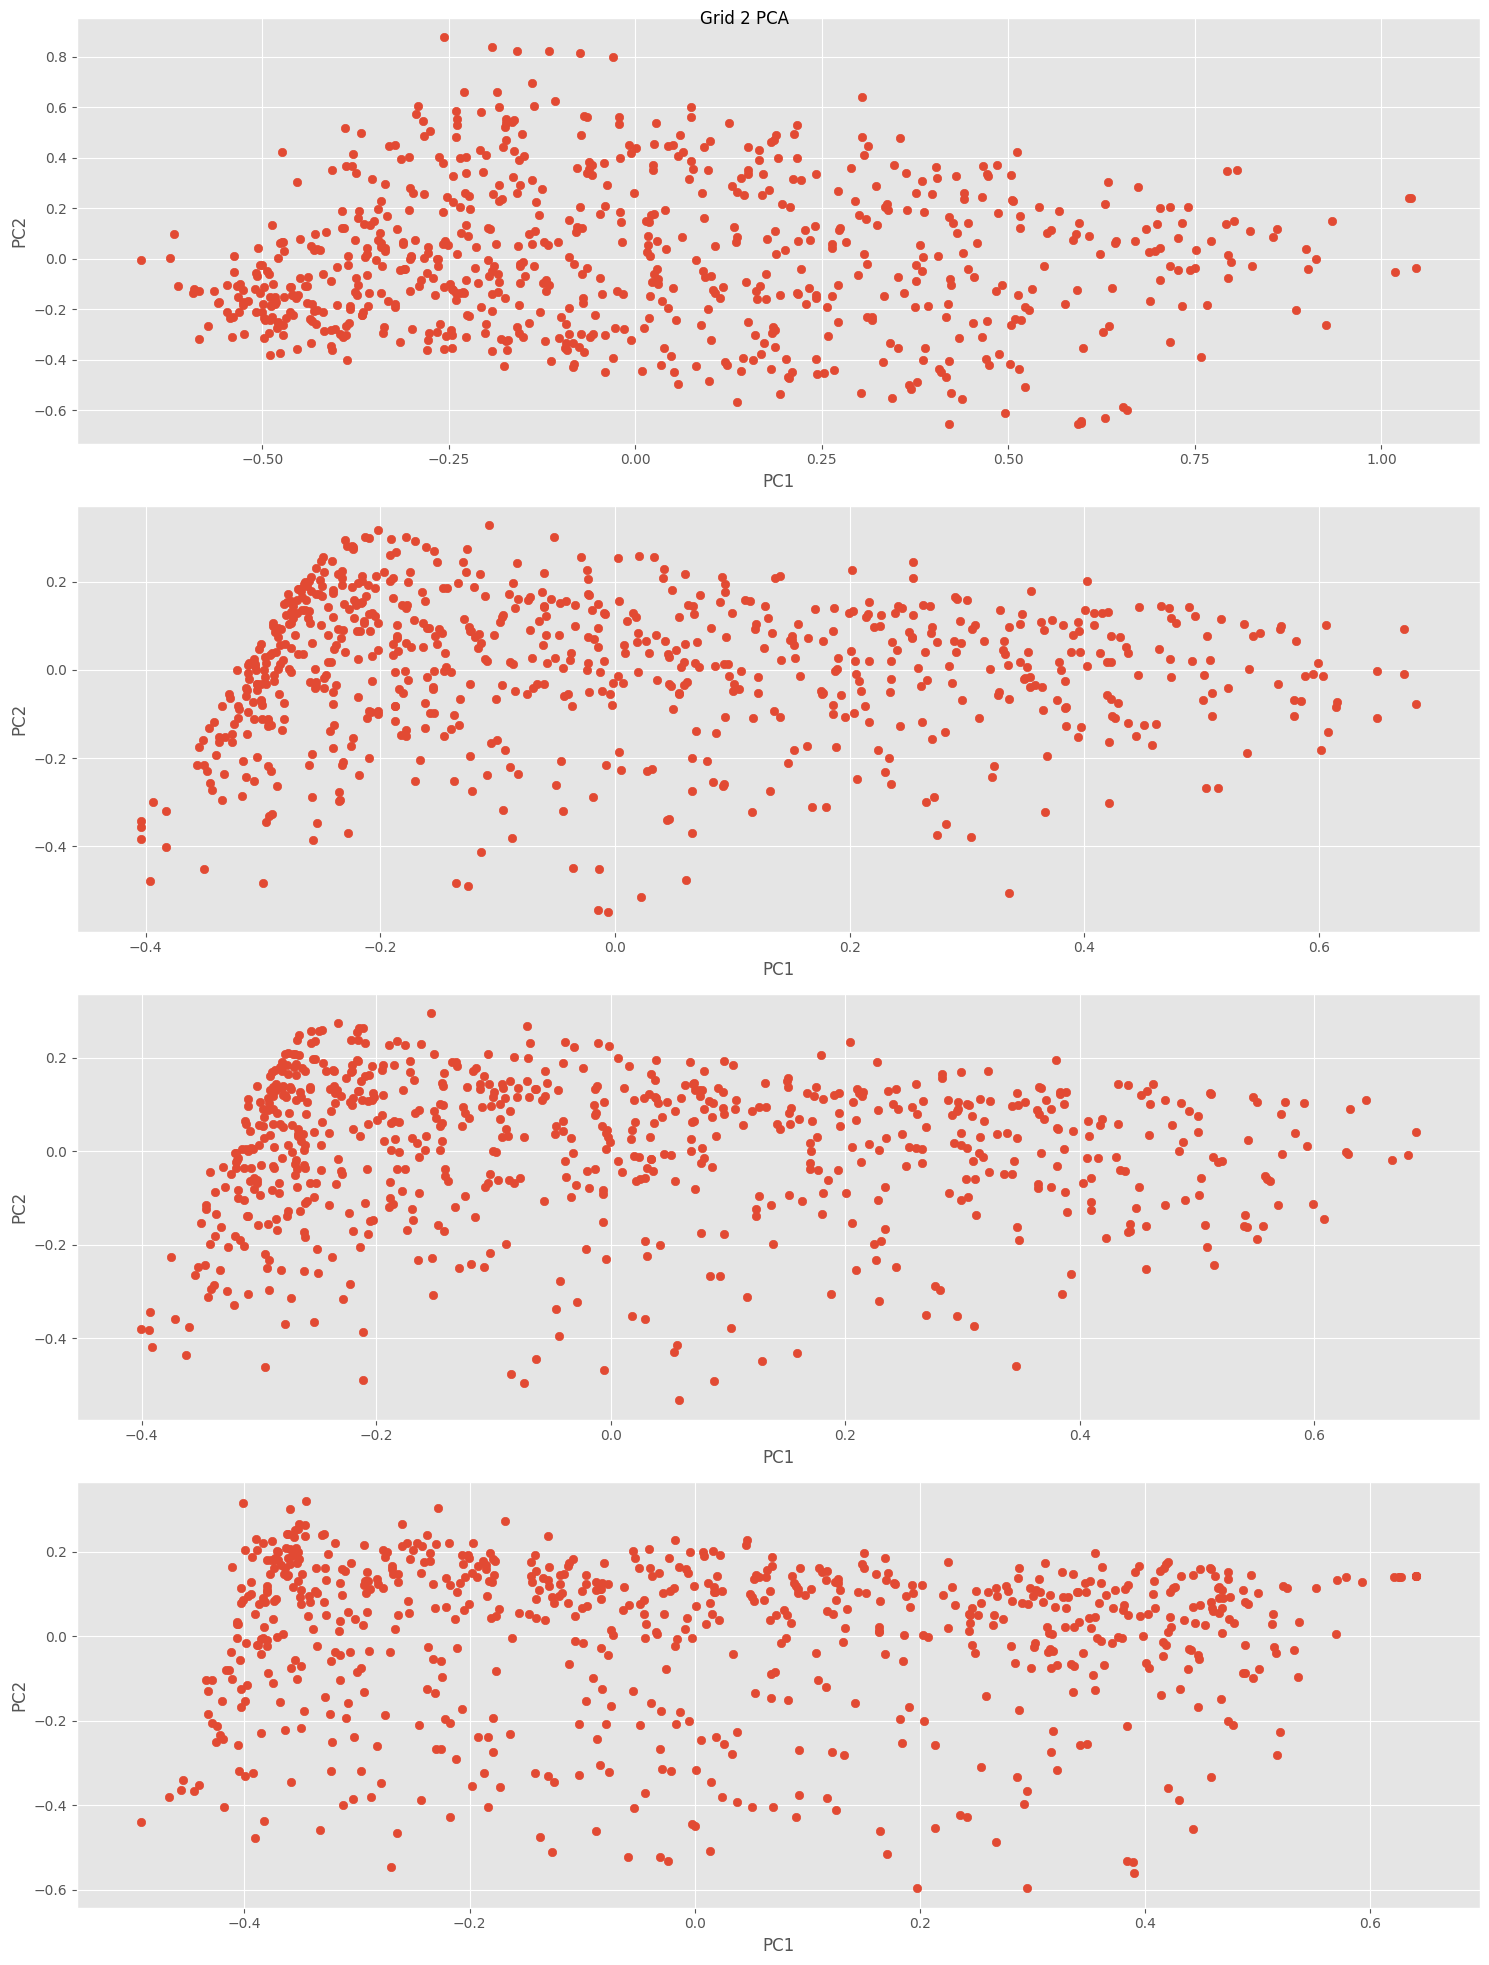

In [31]:
plot_pca(grid2_pca_list, "Grid 2 PCA")

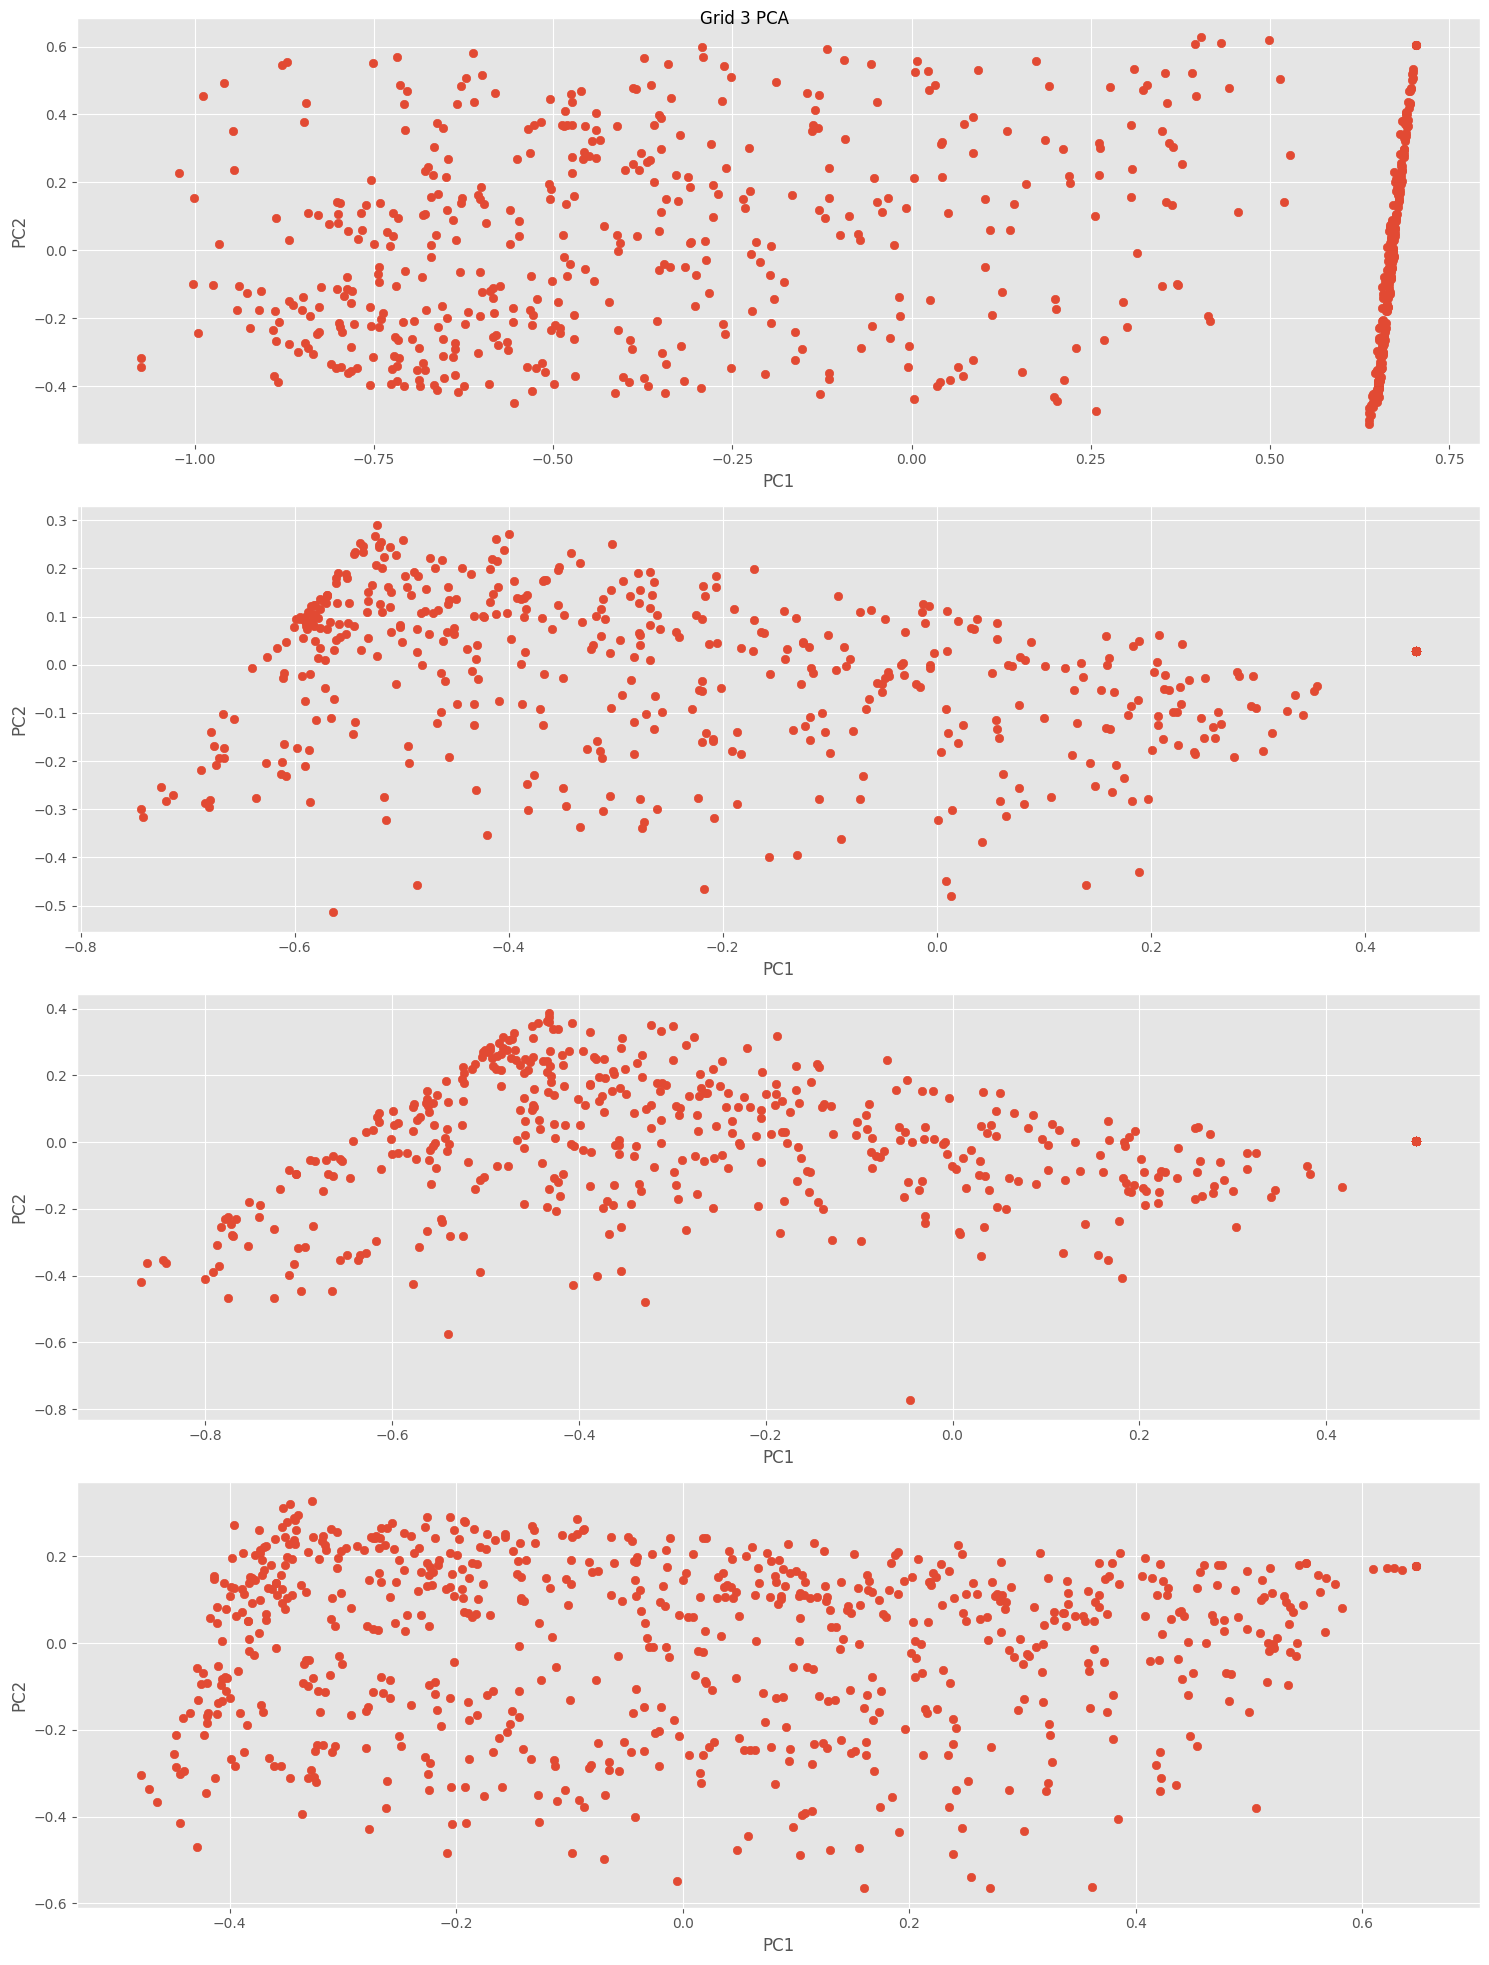

In [32]:
plot_pca(grid3_pca_list, "Grid 3 PCA")

## PCA fit to grid1

## PCA fit to all grids

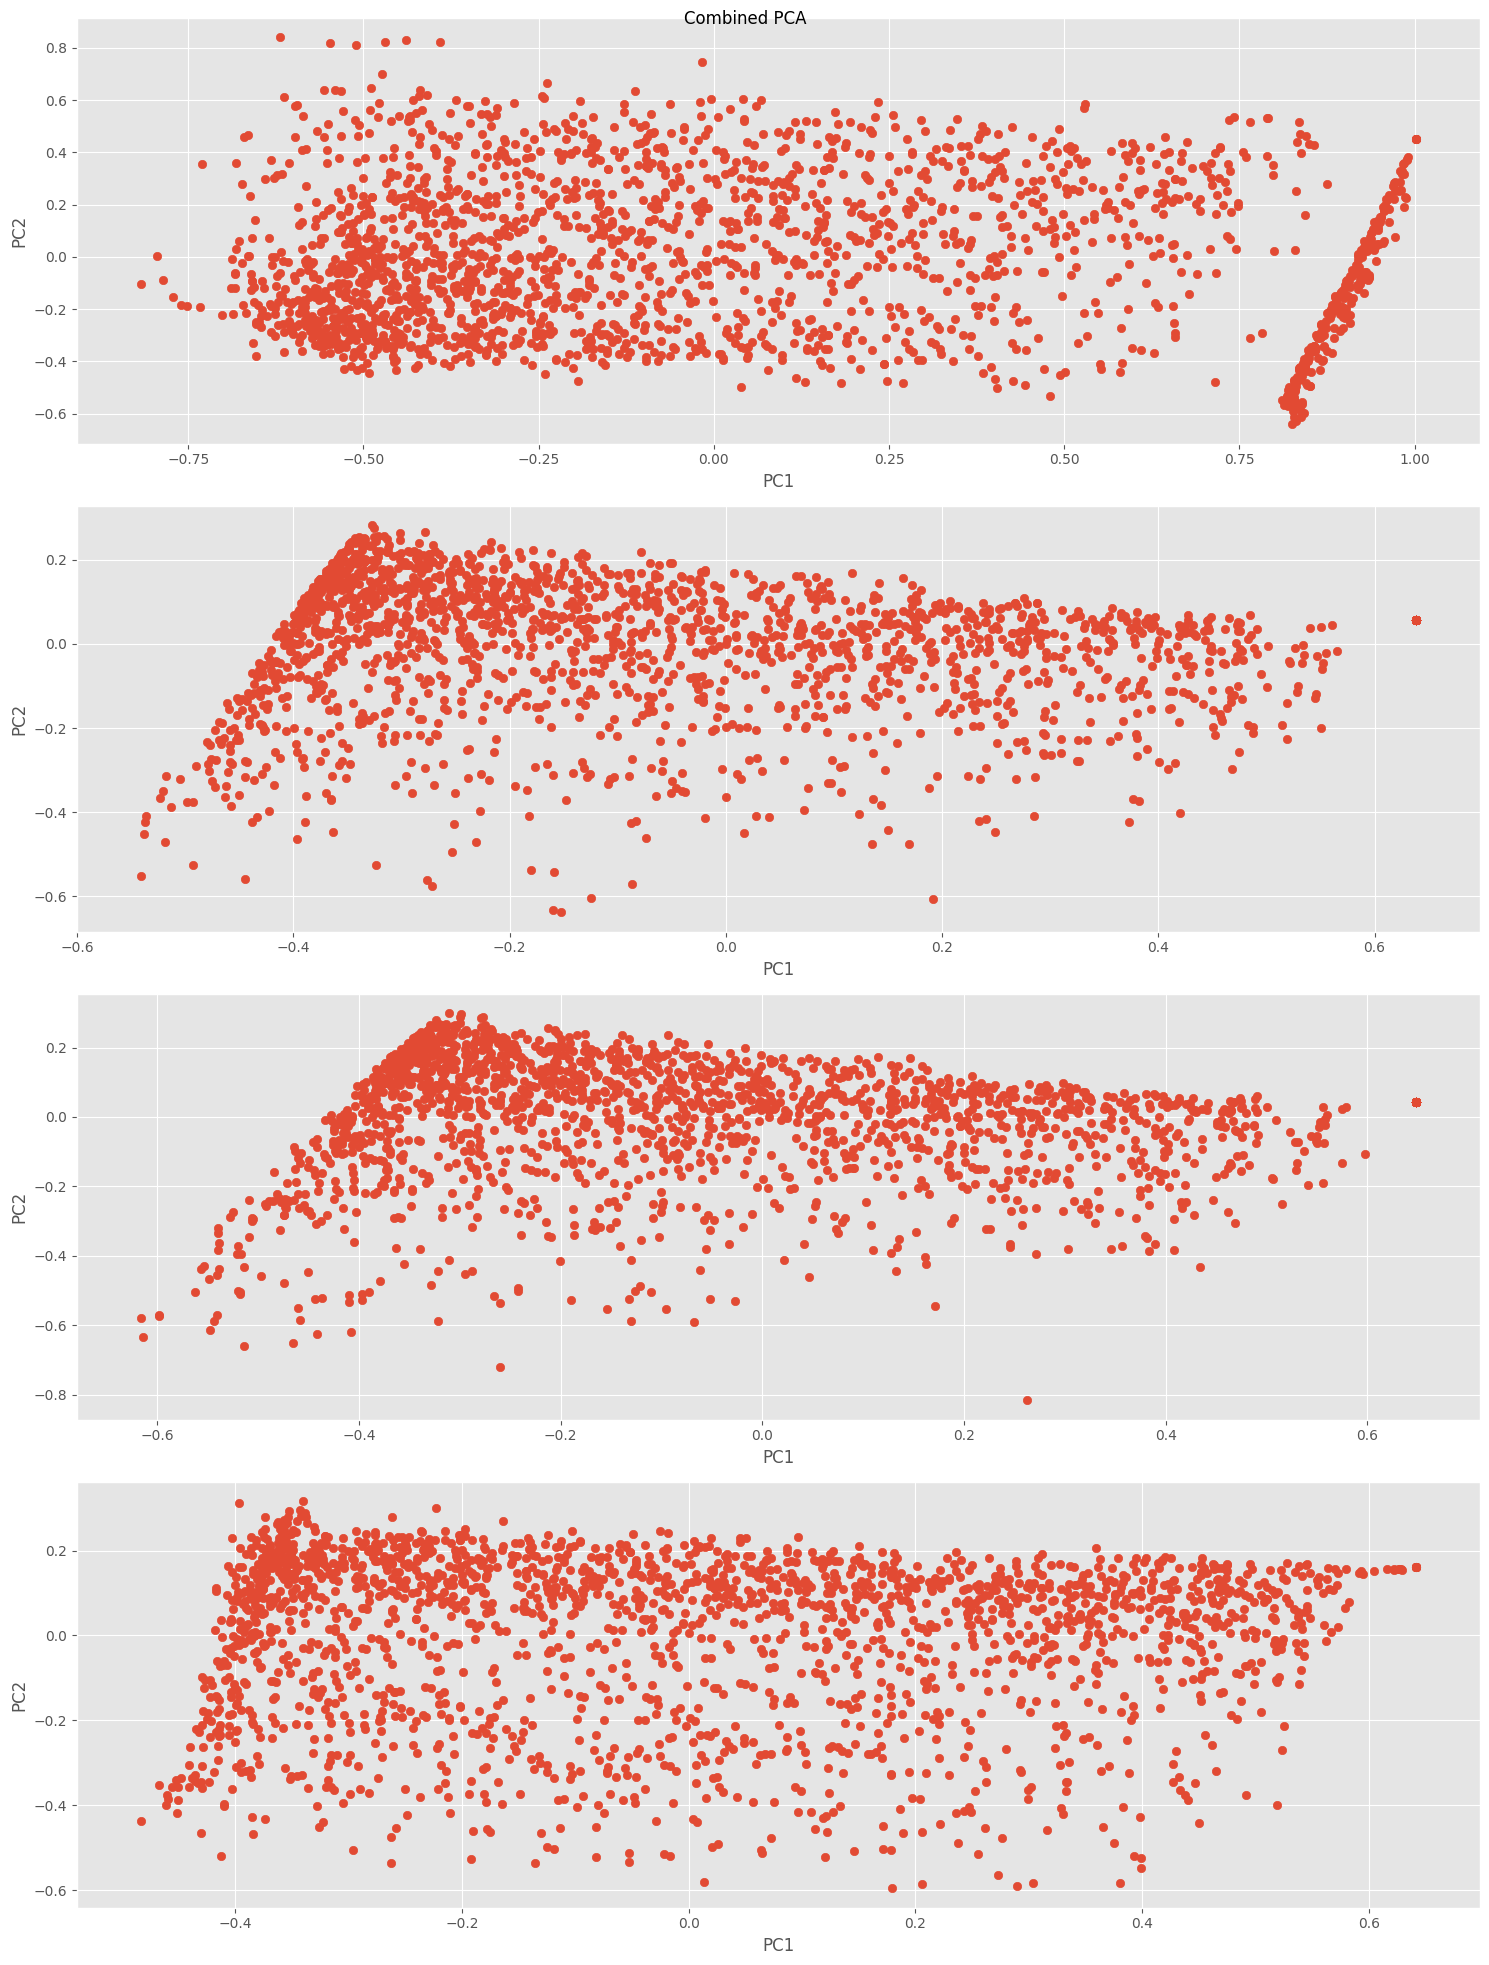

In [33]:
combined_features = np.concatenate((grid1_features, grid2_features, grid3_features), axis=0)

combined_pca_list = mts_and_uts_wise_pca(combined_features)
plot_pca(combined_pca_list, "Combined PCA")